In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import warnings
warnings.filterwarnings(action='ignore')
from catboost import *
import sklearn
import math
from sklearn.preprocessing import LabelEncoder
import math


def log(train,test):
    col_list = train.columns
    for col in col_list :
        if '제곱' in col:
            train[col+'log'] = np.log1p(train[col])
            test[col+'log'] = np.log1p(test[col])
    return train,test

def del_columns(train, test):
    col_list = train.columns
    nan_list = []
    nan_cnt = []
    nan_col = []
    full_list = []
    for col in col_list:
        if train[col].isnull().sum() == 0 :
            full_list.append(col)
            continue
        nan_list.append([col, train[col].isnull().sum()])
        nan_cnt.append(train[col].isnull().sum())
        nan_col.append(col)

    PRODUCT_CODE = train['PRODUCT_CODE'].unique()

    '''모든값이 결측값이면 제거'''
    del_col = []
    for col in nan_list :
        if col[1] == len(train) :
            del_col.append(col[0])
    train = train.drop(columns=del_col)
    test = test.drop(columns=del_col)

    print(PRODUCT_CODE,'모든 값이 결측값인 columns : ', del_col)
    all_nan = len(del_col)

    '''값이 1개 존재하면 제거'''
    del_col = []
    col_list = train.describe().columns
    for col in col_list :
        if col == 'Y_Class':
            continue
        if col == 'Y_Quality':
            continue
        if col == 'LINE':
            continue
        if col == 'PRODUCT_CODE':
            continue
        if train[col].nunique()==1 :
            del_col.append(col)
    train = train.drop(columns=del_col)
    test = test.drop(columns=del_col)
    all_one = len(del_col)

    print(PRODUCT_CODE,'단일 값이 존재하는 columns : ', del_col)
    
    return train,test,all_nan,all_one
   
def make_train_test_dataset(train,test):
    train_x = train.drop(columns=['PRODUCT_ID','TIMESTAMP','PRODUCT_CODE','Y_Class','Y_Quality'])
    test_x = test.drop(columns=['PRODUCT_ID','TIMESTAMP','PRODUCT_CODE'])
    train_y = train['Y_Quality']
    train_w = train[['Y_Class']]
    return train_x, test_x, train_y, train_w

def fillna(train,test,value):
    train = train.fillna(value)
    test = test.fillna(value)
    return train,test

def labelencoder(train,test,col_list):
    qual_col = col_list
    for i in qual_col:
        le = LabelEncoder()
        le = le.fit(train[i])
        train[i] = le.transform(train[i])

        for label in np.unique(test[i]): 
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        test[i] = le.transform(test[i]) 
    return train,test

def multi_col(train,test) : 
    col_list = train.columns
    for col in col_list :
        if col == 'LINE':
            continue
        train[col+'제곱'] = (train[col]**2)//100
        test[col+'제곱'] = (test[col]**2)//100
    return train,test

def cnt_plot(data, col,  hue, title):
    plt.rc('font', family='Malgun Gothic')
    plt.rc("axes",unicode_minus=False)
    plt.figure(figsize=(10,5))
    plt.xticks(rotation=40)
    ax=sns.countplot(x=col, hue=hue ,data = data, palette='Greens')
    for p in ax.patches:
        ax.annotate("%.0f"%p.get_height(),(p.get_x() + p.get_width()/2, p.get_height()),
                   ha='center', va='center', fontsize=14, color='black', xytext=(0,10),
                   textcoords='offset points')
    plt.title(title)
    plt.show()

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/LGaimers/train.csv')
test = pd.read_csv('/content/drive/MyDrive/LGaimers/test.csv')

<AxesSubplot:xlabel='Y_Quality'>

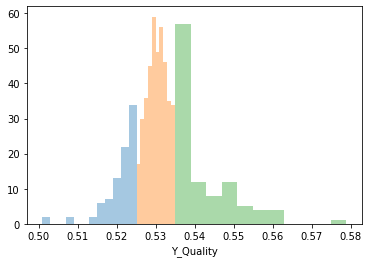

In [ ]:
# 초기 Y-Quality 분포 확인
below_standard_df = train[train['Y_Class']==0]
normal_standard_df = train[train['Y_Class']==1]
over_standard_df = train[train['Y_Class']==2]

sns.distplot(below_standard_df['Y_Quality'], kde=False)
sns.distplot(normal_standard_df['Y_Quality'], kde=False)
sns.distplot(over_standard_df['Y_Quality'], kde=False)

In [ ]:
# y quality scaling
train['Y_Quality'] = train['Y_Quality'].map(lambda x : np.log(x))
#train['Y_Quality'] = train['Y_Quality'].map(lambda x : np.log(1+x))

# train, test = del_columns(train,test)

trainA_31 = train[train['PRODUCT_CODE']=='A_31']
train_T_31 = train[train['PRODUCT_CODE']=='T_31']
train_O_31 = train[train['PRODUCT_CODE']=='O_31']

testA_31 = test[test['PRODUCT_CODE']=='A_31']
test_T_31 = test[test['PRODUCT_CODE']=='T_31']
test_O_31 = test[test['PRODUCT_CODE']=='O_31']

trainA_31, testA_31, A_all_nan, A_all_one = del_columns(trainA_31,testA_31)
train_T_31, test_T_31, T_all_nan, T_all_one = del_columns(train_T_31,test_T_31)
train_O_31, test_O_31, O_all_nan, O_all_one = del_columns(train_O_31,test_O_31)

trainA_31_x,testA_31_x, trainA_31_y, trainA_31_w = make_train_test_dataset(trainA_31,testA_31)
train_T_31_x,test_T_31_x, train_T_31_y, train_T_31_w = make_train_test_dataset(train_T_31,test_T_31)
train_O_31_x,test_O_31_x, train_O_31_y, train_O_31_w = make_train_test_dataset(train_O_31,test_O_31)

trainA_31_x,testA_31_x = labelencoder(trainA_31_x,testA_31_x,['LINE'])
train_T_31_x,test_T_31_x = labelencoder(train_T_31_x,test_T_31_x,['LINE'])
train_O_31_x,test_O_31_x = labelencoder(train_O_31_x,test_O_31_x,['LINE'])

trainA_31_x,testA_31_x = fillna(trainA_31_x,testA_31_x,-1)
train_T_31_x,test_T_31_x = fillna(train_T_31_x,test_T_31_x,-1)
train_O_31_x,test_O_31_x = fillna(train_O_31_x,test_O_31_x,-1)

print(trainA_31_x.shape,testA_31_x.shape,train_T_31_x.shape,test_T_31_x.shape)

['A_31'] 모든 값이 결측값인 columns :  ['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15', 'X_16', 'X_17', 'X_18', 'X_19', 'X_20', 'X_21', 'X_22', 'X_23', 'X_24', 'X_25', 'X_26', 'X_27', 'X_28', 'X_29', 'X_30', 'X_31', 'X_32', 'X_33', 'X_34', 'X_35', 'X_36', 'X_37', 'X_38', 'X_39', 'X_40', 'X_41', 'X_42', 'X_43', 'X_44', 'X_45', 'X_46', 'X_47', 'X_48', 'X_49', 'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56', 'X_57', 'X_58', 'X_59', 'X_60', 'X_61', 'X_62', 'X_63', 'X_64', 'X_65', 'X_66', 'X_67', 'X_68', 'X_69', 'X_70', 'X_71', 'X_72', 'X_73', 'X_74', 'X_75', 'X_76', 'X_77', 'X_78', 'X_79', 'X_80', 'X_81', 'X_82', 'X_83', 'X_84', 'X_85', 'X_86', 'X_87', 'X_88', 'X_89', 'X_90', 'X_91', 'X_92', 'X_93', 'X_94', 'X_95', 'X_96', 'X_97', 'X_98', 'X_99', 'X_100', 'X_101', 'X_102', 'X_103', 'X_104', 'X_105', 'X_106', 'X_107', 'X_108', 'X_109', 'X_110', 'X_111', 'X_112', 'X_113', 'X_114', 'X_115', 'X_116', 'X_117', 'X_118', 'X_119', 'X_12

In [ ]:
print(A_all_nan,A_all_one, T_all_nan, T_all_one, O_all_nan, O_all_one)

759 251 2198 128 2208 169


In [ ]:
del_col = pd.DataFrame()
del_col_list = ['A_all_nan','A_all_one','T_all_nan','T_all_one','O_all_nan','O_all_one']
del_col['del_col'] = [A_all_nan,A_all_one,T_all_nan,T_all_one,O_all_nan,O_all_one]

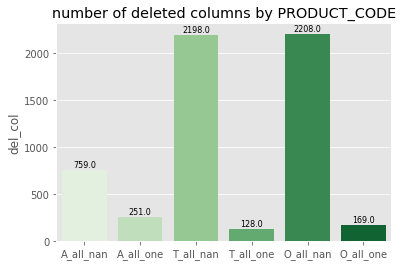

In [ ]:
ax = sns.barplot(
    data= del_col,
    x= del_col_list,
    y= "del_col",
    palette='Greens'
)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 30, height, ha = 'center', size = 8)
plt.title('number of deleted columns by PRODUCT_CODE')
plt.style.use('ggplot')
plt.show()

In [ ]:
processed_df = pd.DataFrame()
processed_df['processed columns'] = [trainA_31.shape[1], train_T_31.shape[1], train_O_31.shape[1]]

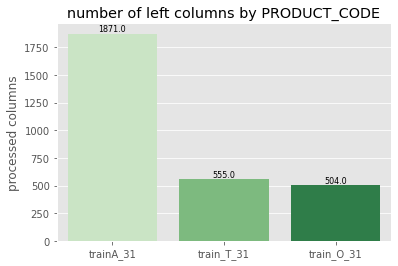

In [ ]:
ax = sns.barplot(
    data= processed_df,
    x= ['trainA_31', 'train_T_31', 'train_O_31'],
    y= "processed columns",
    palette='Greens'
)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 20, height, ha = 'center', size = 8)
plt.title('number of left columns by PRODUCT_CODE')
plt.style.use('ggplot')
plt.show()

<AxesSubplot:xlabel='Y_Quality'>

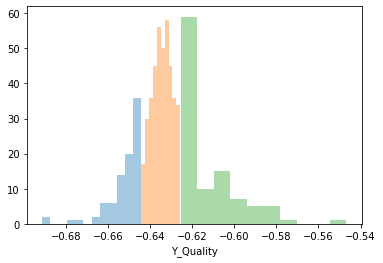

In [ ]:
# log2 scaling 이후 분포
below_standard_df = train[train['Y_Class']==0]
normal_standard_df = train[train['Y_Class']==1]
over_standard_df = train[train['Y_Class']==2]

sns.distplot(below_standard_df['Y_Quality'], kde=False)
sns.distplot(normal_standard_df['Y_Quality'], kde=False)
sns.distplot(over_standard_df['Y_Quality'], kde=False)

In [ ]:
max_0 = train[train['Y_Class']==0]['Y_Quality'].max()
min_1 = train[train['Y_Class']==1]['Y_Quality'].min()
max_1 = train[train['Y_Class']==1]['Y_Quality'].max()
min_2 = train[train['Y_Class']==2]['Y_Quality'].min()

print(max_0, min_1, max_1, min_2)

-0.6442300396904909 -0.6441937649548493 -0.6257823004654807 -0.6255805101477584


In [ ]:
model1 = CatBoostRegressor(random_state=7,verbose=500,iterations=1500,learning_rate=0.033)

In [ ]:
model1.fit(trainA_31_x, trainA_31_y)
pred_a = model1.predict(testA_31_x)

0:	learn: 0.0183488	total: 226ms	remaining: 5m 39s
500:	learn: 0.0012223	total: 1m	remaining: 2m
1000:	learn: 0.0001159	total: 2m 3s	remaining: 1m 1s
1499:	learn: 0.0000111	total: 3m 4s	remaining: 0us


In [ ]:
model1.fit(train_T_31_x, train_T_31_y)
pred_t = model1.predict(test_T_31_x)

0:	learn: 0.0089231	total: 30.2ms	remaining: 45.3s
500:	learn: 0.0009467	total: 21.8s	remaining: 43.5s
1000:	learn: 0.0001108	total: 43.6s	remaining: 21.7s
1499:	learn: 0.0000138	total: 1m 11s	remaining: 0us


In [ ]:
model1.fit(train_O_31_x, train_O_31_y)
pred_o = model1.predict(test_O_31_x)

0:	learn: 0.0059646	total: 3.56ms	remaining: 5.33s
500:	learn: 0.0000894	total: 2.17s	remaining: 4.33s
1000:	learn: 0.0000014	total: 4.44s	remaining: 2.21s
1499:	learn: 0.0000000	total: 6.85s	remaining: 0us


In [ ]:
testA_31['Y_quanlity'] = pred_a
test_T_31['Y_quanlity'] = pred_t
test_O_31['Y_quanlity'] = pred_o

testA_31['Y_Class'] = 1
test_T_31['Y_Class'] = 1
test_O_31['Y_Class'] = 1

testA_31.loc[(testA_31['Y_quanlity']<=(max_0+min_1)/2), 'Y_Class'] = 0
testA_31.loc[(testA_31['Y_quanlity']>=(max_1 + min_2)/2), 'Y_Class'] = 2
test_T_31.loc[(test_T_31['Y_quanlity']<=(max_0+min_1)/2), 'Y_Class'] = 0
test_T_31.loc[(test_T_31['Y_quanlity']>=(max_1 + min_2)/2), 'Y_Class'] = 2
test_O_31.loc[(test_O_31['Y_quanlity']<=(max_0+min_1)/2), 'Y_Class'] = 0
test_O_31.loc[(test_O_31['Y_quanlity']>=(max_1 + min_2)/2), 'Y_Class'] = 2

submita = pd.read_csv('/content/drive/MyDrive/LGaimers/sample_submission.csv')
submitt = pd.read_csv('/content/drive/MyDrive/LGaimers/sample_submission.csv')
submito = pd.read_csv('/content/drive/MyDrive/LGaimers/sample_submission.csv')

submita = pd.merge(submita[['PRODUCT_ID']],testA_31[['PRODUCT_ID','Y_Class']],on='PRODUCT_ID')
submitt = pd.merge(submitt[['PRODUCT_ID']],test_T_31[['PRODUCT_ID','Y_Class']],on='PRODUCT_ID')
submito = pd.merge(submito[['PRODUCT_ID']],test_O_31[['PRODUCT_ID','Y_Class']],on='PRODUCT_ID')

pd.concat([submita,submitt,submito]).sort_values(by='PRODUCT_ID').to_csv('scale1.csv',index=False)

In [ ]:
df = pd.read_csv('scale1.csv')

In [ ]:
df['Y_Class'].value_counts()

1    264
0     38
2      8
Name: Y_Class, dtype: int64

In [ ]:
df[df['Y_Class']==2] # 234, 5500, 0.02

,PRODUCT_ID,Y_Class
38,TEST_038,2
108,TEST_108,2
160,TEST_160,2
161,TEST_161,2
163,TEST_163,2
169,TEST_169,2
179,TEST_179,2
183,TEST_183,2


seed 234
- 0 : 34
- 1 : 266
- 2 : 10

seed : 34
- 0 : 33
- 1 : 273
- 2 : 4

seed : 4
- 0 : 42
- 1 : 258
- 2 : 10

seed : 6
- 0 : 34
- 1 : 269
- 2 : 7

seed : 7
- 0 : 38
- 1 : 264
- 2 : 8

seed : 8
- 0 : 30
- 1 : 275
- 2 : 5

seed : 12
- 0 : 35
- 1 : 267
- 2 : 8

seed : 50
- 0 : 25
- 1 : 277
- 2 : 8

seed : 2345
- 0 : 23
- 1 : 280
- 2 : 7

seed : 9
- 0 : 23
- 1 : 280
- 2 : 7

seed : 99
- 0 : 35
- 1 : 266
- 2 : 9

seed : 999
- 0 : 26
- 1 : 281
- 2 : 3

seed : 9000
- 0 : 24
- 1 : 277
- 2 : 9

In [ ]:
n_df = pd.read_csv('ln_scale1.csv')
ln_df['Y_Class'].value_counts()

FileNotFoundError: ignored

In [ ]:
from collections import Counter
Counter(df['Y_Class'] != ln_df['Y_Class'])